# Riprompt Mechanics and Mathematics

This notebook implements the mechanics and mathematics described in `riprompt.txt` using Python and matplotlib for visualization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def τ(q, k):
    """
    Vectorized, numerically robust computation of τ(q, k) = (2*q**3 + 1) / (3*q**2 - 2 + k).
    Returns np.nan where denominator is (or is very close to) zero.
    """
    q = np.asarray(q, dtype=np.float64)
    k = np.asarray(k, dtype=np.float64)
    numerator = 2 * q**3 + 1
    denominator = 3 * q**2 - 2 + k
    # Use np.isclose to robustly identify (near-)zero denominators
    mask = np.isclose(denominator, 0, atol=1e-10)
    result = np.divide(numerator, denominator, out=np.full_like(numerator, np.nan), where=~mask)
    result = np.where(mask, np.nan, result)
    return result

## Eigenvalues as Fixed Points of the Tau Iteration

The `riprompt.txt` file defines a relationship `τ ← (2τ³ + 1) / (3τ² - 2 + 💓) ⟿ Λ[💓]`. This implies that the eigenvalues `Λ[💓]` (denoted as `Λ_k` where `k = 💓 % 5`) are fixed points of the iteration `q_new = τ(q_old, k)`.
A fixed point `q` satisfies `q = τ(q, k)`.
Substituting the definition of `τ(q, k)`:
`q = (2q³ + 1) / (3q² - 2 + k)`
`q(3q² - 2 + k) = 2q³ + 1`
`3q³ - 2q + kq = 2q³ + 1`
`q³ + (k-2)q - 1 = 0`

This is precisely the set of polynomial equations whose roots are defined as `Λ_k` in `riprompt.txt`:
- For `k=0 (💓₀)`: `q³ - 2q - 1 = 0`
- For `k=1 (💓₁)`: `q³ - q - 1 = 0`
- For `k=2 (💓₂)`: `q³ - 1 = 0`
- For `k=3 (💓₃)`: `q³ + q - 1 = 0`
- For `k=4 (💓₄)`: `q³ + 2q - 1 = 0`

The following plots will visualize this by showing the intersection of `y = q` and `y = τ(q, k)` for each `k`, with the calculated `Λ_k` highlighted at these intersections.


Eigenvalues Λ_k for k=0..4:
k=0: [ 1.618034 -1.       -0.618034]
k=1: [ 1.324718 -0.662359 -0.662359]
k=2: [-0.5 -0.5  1. ]
k=3: [-0.341164 -0.341164  0.682328]
k=4: [-0.226699 -0.226699  0.453398]


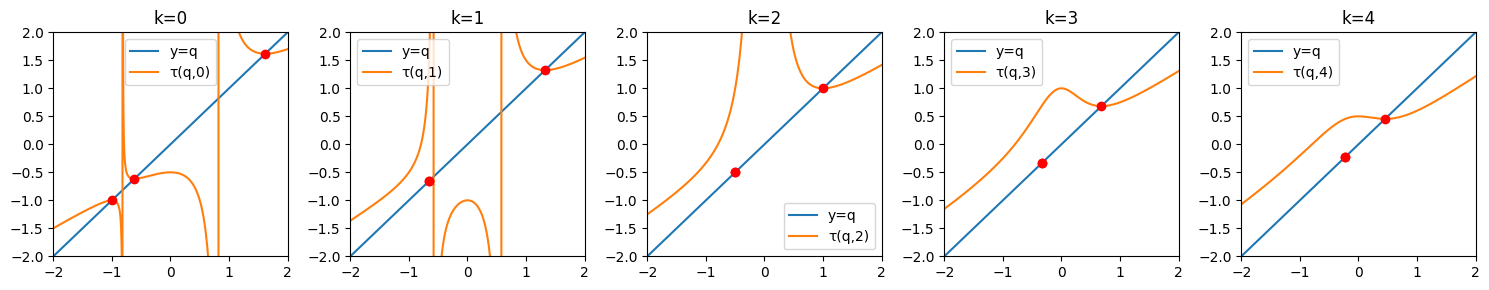

In [2]:
ks = np.arange(5)
roots = {k: np.roots([1, 0, k-2, -1]).real for k in ks}

print("Eigenvalues Λ_k for k=0..4:")
for k, r in roots.items():
    print(f"k={k}: {np.round(r,6)}")

q_vals = np.linspace(-2, 2, 1001)
fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i, k in enumerate(ks):
    ax = axes[i]
    ax.set_ylim(-2, 2)
    ax.margins(x=0, y=0)
    ax.plot(q_vals, q_vals, label='y=q')
    ax.plot(q_vals, τ(q_vals, k), label=f'τ(q,{k})')
    for root in roots[k]:
        ax.plot(root, root, 'ro')
    ax.set_title(f'k={k}')
    ax.legend()
plt.tight_layout()
plt.show()

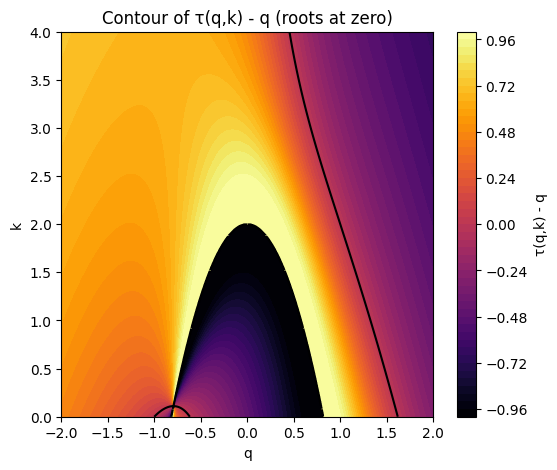

In [3]:
q = np.linspace(-2, 2, 1001)
k = np.linspace(0, 4, 1001)
Q, K = np.meshgrid(q, k)
F = np.tanh(τ(Q, K) - Q)

plt.figure(figsize=(6,5))
contour = plt.contourf(Q, K, F, levels=50, cmap='inferno')
plt.colorbar(contour, label='τ(q,k) - q')
plt.contour(Q, K, F, levels=[0], colors='k')
plt.xlabel('q')
plt.ylabel('k')
plt.title('Contour of τ(q,k) - q (roots at zero)')
plt.show()

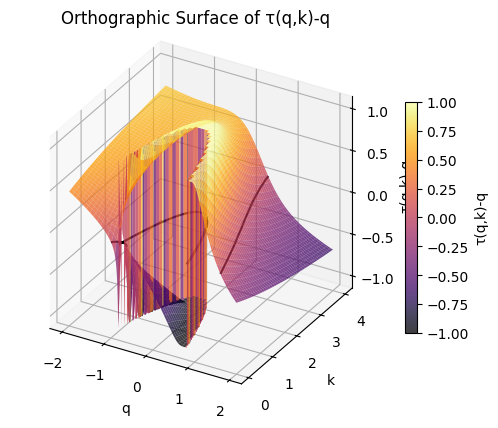

In [4]:
q = np.linspace(-2, 2, 1001)
k = np.linspace(0, 4, 1001)
Q, K = np.meshgrid(q, k)
F = np.tanh(τ(Q, K) - Q)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')
surf = ax.plot_surface(Q, K, F, cmap='inferno', edgecolor='none', vmin=-1, vmax=1, alpha=0.75)
ax.contour(Q, K, F, levels=[0], zdir='z', colors='black')
ax.set_xlabel('q')
ax.set_ylabel('k')
ax.set_zlabel('τ(q,k)-q')
ax.set_box_aspect((1,1,1))
fig.colorbar(surf, shrink=0.5, label='τ(q,k)-q')
plt.title('Orthographic Surface of τ(q,k)-q')
plt.show()

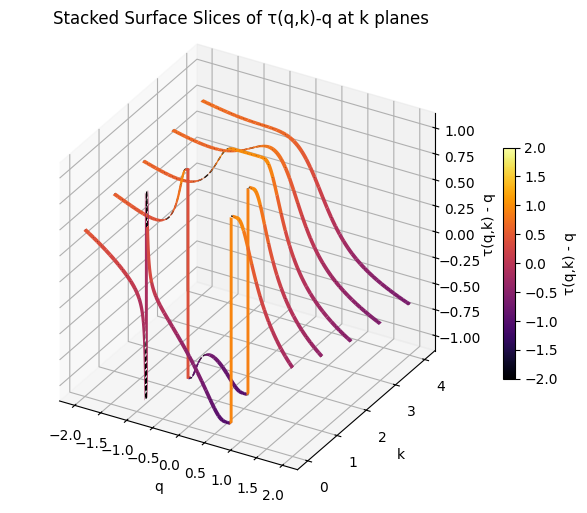

In [5]:
q = np.linspace(-2, 2, 10001)
k_values = np.linspace(0, 4, 5)
dy = 0.05  # small slab thickness in k direction

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')
# Plot thin surface slabs for each k
for k in k_values:
    F = np.tanh(τ(q, k) - q)
    # Build a thin slab in k-direction
    Qs = np.vstack([q, q])
    Ks = np.vstack([np.full_like(q, k-dy), np.full_like(q, k+dy)])
    Fs = np.vstack([F, F])
    surf = ax.plot_surface(Qs, Ks, Fs, cmap='inferno', edgecolor='none', vmin=-2, vmax=2)
    # Zero-level contour line on each slab center
    ax.plot(q, np.full_like(q, k), F, 'k--', linewidth=1)

ax.set_xlabel('q')
ax.set_ylabel('k')
ax.set_zlabel('τ(q,k) - q')
ax.set_box_aspect((1,1,1))
fig.colorbar(surf, shrink=0.5, label='τ(q,k) - q')
plt.title('Stacked Surface Slices of τ(q,k)-q at k planes')
plt.show()